# GISTDA Wildfire Machine Learning Training

## Import and Read SHAPE File

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rasterio
import logging
import pickle
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown
from dask import delayed, compute
from rasterio.windows import Window
from typing import Tuple, Dict, Any


#pd.set_option("display.max_columns", None)  # To show all columns in a pandas DataFrame

# Define the folder containing the raster files
raster_train_file_path = r'Raster_Train'

# Parameters for chunk size
CHUNK_SIZE = 1024

@delayed
def read_raster_in_chunks(raster_path, file, root):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        num_bands = src.count
        band_names = [f'B{str(i).zfill(2)}' for i in range(1, num_bands + 1)]
        chunk_dfs = []
        
        # Loop over the raster in chunks
        for row in range(0, height, CHUNK_SIZE):
            for col in range(0, width, CHUNK_SIZE):
                window = Window(col_off=col, row_off=row, 
                              width=min(CHUNK_SIZE, width - col),
                              height=min(CHUNK_SIZE, height - row))
                
                # Read all bands at once
                data = src.read(window=window)
                
                # Check if chunk contains any data
                if np.any(data):
                    rows, cols = data[0].shape
                    
                    # Create base DataFrame with coordinates
                    row_coords, col_coords = np.meshgrid(
                        np.arange(row, row + rows),
                        np.arange(col, col + cols),
                        indexing="ij"
                    )
                    
                    chunk_df = pd.DataFrame({
                        'raster_file': file,
                        'subfolder': os.path.basename(root),
                        'x': row_coords.flatten(),
                        'y': col_coords.flatten()
                    })
                    
                    # Add each band's data
                    for band_idx, band_name in enumerate(band_names, 1):
                        chunk_df[band_name] = data[band_idx-1].flatten()
                    
                    chunk_dfs.append(chunk_df)
        
        return pd.concat(chunk_dfs, ignore_index=True) if chunk_dfs else pd.DataFrame()

# Create list of tasks
dask_dfs = [
    read_raster_in_chunks(os.path.join(root, file), file, root)
    for root, dirs, files in os.walk(raster_train_file_path)
    for file in files if file.endswith('.tif')
]

# Compute all tasks
dataframes = compute(*dask_dfs)

# Combine all DataFrames
final_df = pd.concat(dataframes, ignore_index=True)

# Debug prints
print("DataFrame shape:", final_df.shape)
print("\nDataFrame columns:", final_df.columns.tolist())
print("\nSample of data:")
print(final_df.head())

DataFrame shape: (48168960, 20)

DataFrame columns: ['raster_file', 'subfolder', 'x', 'y', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16']

Sample of data:
                            raster_file     subfolder  x  y    B01     B02  \
0  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  0    1.0  1554.0   
1  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  1    1.0  1600.0   
2  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  2  603.0  1592.0   
3  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  3  603.0  1678.0   
4  T46QGF_20230316T040541_chunk_0_0.tif  Raster_Train  0  4  858.0  1698.0   

      B03     B04     B05     B06     B07     B08     B09     B10     B11  \
0  1752.0  1930.0  2277.0  2576.0  2712.0  2812.0  2959.0  3042.0  3627.0   
1  1788.0  1912.0  2277.0  2576.0  2712.0  2850.0  2959.0  3042.0  3627.0   
2  1790.0  2002.0  2413.0  2643.0  2836.0  2782.0  3120.0  3042.0  3786.0   
3  

## Feature Engineering

In [2]:
# Convert pandas DataFrame to dask DataFrame if already loaded
ddf = pd.DataFrame(final_df)  # Adjust number of partitions as needed

## Rename Sentinel-2 Bands columns and Burn Label
# List of new column names
new_col_names = ['raster_file', 'subfolder', 'x', 'y', 'Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 
                 'Band_6', 'Band_7', 'Band_8', 'Band_8A', 'Band_9', 'Band_11', 'Band_12', 'dNBR',
                 'NDVI', 'NDWI', 'Burn_Label']


# Renaming columns using the list
ddf.columns = new_col_names

# Drop columns in dask
df = ddf.drop(columns=['raster_file', 'subfolder', 'x', 'y', 'dNBR'])
display(df)  # Compute only when you need to display or save results

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,1.0,1554.0,1752.0,1930.0,2277.0,2576.0,2712.0,2812.0,2959.0,3042.0,3627.0,2993.0,0.185997,-0.232252,0.0
1,1.0,1600.0,1788.0,1912.0,2277.0,2576.0,2712.0,2850.0,2959.0,3042.0,3627.0,2993.0,0.196976,-0.228978,0.0
2,603.0,1592.0,1790.0,2002.0,2413.0,2643.0,2836.0,2782.0,3120.0,3042.0,3786.0,3110.0,0.163043,-0.216973,0.0
3,603.0,1678.0,1863.0,2142.0,2413.0,2643.0,2836.0,2974.0,3120.0,3042.0,3786.0,3110.0,0.162627,-0.229688,0.0
4,858.0,1698.0,1932.0,2224.0,2504.0,2747.0,2843.0,3004.0,3109.0,3042.0,3696.0,3002.0,0.149197,-0.217180,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48168955,1319.0,1414.0,1513.0,1607.0,1737.0,2038.0,2220.0,2604.0,2544.0,2814.0,2814.0,2122.0,0.236761,-0.264999,0.0
48168956,1316.0,1412.0,1553.0,1614.0,1949.0,2269.0,2510.0,2838.0,2772.0,3203.0,3053.0,2263.0,0.274933,-0.292644,0.0
48168957,1316.0,1414.0,1556.0,1645.0,1949.0,2269.0,2510.0,2721.0,2772.0,3203.0,3053.0,2263.0,0.246450,-0.272387,0.0
48168958,1319.0,1412.0,1555.0,1694.0,2064.0,2489.0,2743.0,2819.0,3086.0,3203.0,3337.0,2494.0,0.249280,-0.288980,0.0


## Check Burn Class

In [3]:
# Check Burn Records
burn_counts = df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Unburn    40165739
Burn       8003221
Name: count, dtype: int64


### Downsampling

In [4]:
burn_count = burn_counts['Burn']
unburn_sample = df[df['Burn_Label'] == 0].sample(n=burn_count, random_state=42)

downsampled_df = pd.concat([df[df['Burn_Label'] == 1], unburn_sample])

# Check Burn Records
burn_counts = downsampled_df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Burn      8003221
Unburn    8003221
Name: count, dtype: int64


## Pre-Processing

### Remove infinite values

In [5]:
# Replacing infinite with nan 
downsampled_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
downsampled_df.dropna(inplace=True)

# Printing df 
display(downsampled_df)

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
18,703.0,1614.0,1767.0,1956.0,2193.0,2333.0,2382.0,2498.0,2556.0,2473.0,3356.0,3200.0,0.121688,-0.171395,1.0
19,703.0,1650.0,1800.0,1977.0,2193.0,2333.0,2382.0,2410.0,2556.0,2473.0,3356.0,3200.0,0.098701,-0.144893,1.0
20,729.0,1689.0,1796.0,1990.0,2155.0,2194.0,2286.0,2272.0,2405.0,2473.0,3118.0,3100.0,0.066166,-0.117011,1.0
21,729.0,1672.0,1846.0,1990.0,2155.0,2194.0,2286.0,2266.0,2405.0,2473.0,3118.0,3100.0,0.064850,-0.102140,1.0
22,740.0,1706.0,1822.0,1996.0,2122.0,2159.0,2214.0,2234.0,2317.0,2473.0,3010.0,3035.0,0.056265,-0.101578,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41563308,1322.0,1467.0,1654.0,1686.0,2144.0,2883.0,3140.0,3526.0,3631.0,3584.0,3314.0,2338.0,0.353031,-0.361390,0.0
16455620,1543.0,1550.0,1766.0,1730.0,2164.0,2998.0,3291.0,3924.0,3539.0,3222.0,3090.0,2199.0,0.388044,-0.379262,0.0
25256050,1411.0,1480.0,1723.0,1762.0,2199.0,2805.0,3027.0,3100.0,3400.0,3325.0,3209.0,2277.0,0.275195,-0.285507,0.0
6093295,1515.0,1624.0,1884.0,2156.0,2470.0,2602.0,2855.0,3004.0,3193.0,3030.0,4361.0,3467.0,0.164341,-0.229133,0.0


### Seperate Burn_Label from DataFrame

In [6]:
# Seperate Burn_Label from DataFrame
burn_label = downsampled_df[['Burn_Label']]

# Drop Label from DataFrame
downsampled_df = downsampled_df.drop(columns=['Burn_Label'])

# Change type of Label to Integer Format
burn_label = burn_label.astype('int32')
display(burn_label)

,Burn_Label
18,1
19,1
20,1
21,1
22,1
...,...
41563308,0
16455620,0
25256050,0
6093295,0


### Normalization Data with MinMax Scaler

In [7]:
# Reassign the dataframe with a list of the columns
cols_norm = downsampled_df.columns.tolist()

# Import Normalize technique
scaler = MinMaxScaler()

# Normalize data
scaler.fit(downsampled_df)

# Save the scaler
scaler_save_path = r'Export Model'
save_path = os.path.join(scaler_save_path, 'MinMax_Scaler_FCNN.pkl')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Normalize Data
df_norm = scaler.transform(downsampled_df)
df_norm = pd.DataFrame(df_norm, columns=cols_norm)

# Check df_norm shape after normalization
print("Shape of df_norm after normalization:", df_norm.shape)

# Concatenate df_norm with burn_label
df_norm = pd.concat([df_norm.reset_index(drop=True), burn_label.reset_index(drop=True)], axis=1, sort=False)
display(df_norm)

Shape of df_norm after normalization: (16006442, 14)


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_9,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,0.125326,0.129146,0.142650,0.108948,0.215784,0.229196,0.186645,0.107862,0.222532,0.300147,0.155787,0.139978,0.351473,0.544140,1
1,0.125326,0.137107,0.149482,0.111441,0.215784,0.229196,0.186645,0.100358,0.222532,0.300147,0.155787,0.139978,0.324234,0.577361,1
2,0.130973,0.145732,0.148654,0.112984,0.206724,0.204690,0.171383,0.088591,0.201452,0.300147,0.139554,0.133560,0.285683,0.612311,1
3,0.130973,0.141973,0.159006,0.112984,0.206724,0.204690,0.171383,0.088080,0.201452,0.300147,0.139554,0.133560,0.284123,0.630952,1
4,0.133362,0.149491,0.154037,0.113696,0.198855,0.198519,0.159936,0.085351,0.189167,0.300147,0.132187,0.129388,0.273951,0.631657,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16006437,0.259774,0.096639,0.119255,0.076905,0.204101,0.326164,0.307154,0.195515,0.372609,0.533993,0.152923,0.084654,0.625597,0.305978,0
16006438,0.307776,0.114993,0.142443,0.082127,0.208870,0.346439,0.331161,0.229451,0.359765,0.457798,0.137644,0.075733,0.667084,0.283575,0
16006439,0.279105,0.099513,0.133540,0.085925,0.217215,0.312412,0.289189,0.159192,0.340360,0.479478,0.145761,0.080739,0.533367,0.401099,0
16006440,0.301694,0.131358,0.166874,0.132685,0.281831,0.276622,0.261844,0.151006,0.311462,0.417386,0.224337,0.157114,0.402013,0.471765,0


2024-11-29 08:17:01,825 - INFO - GPU configured successfully: /physical_device:GPU:0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9


2024-11-29 08:17:01,957 - INFO - Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9


Epoch 1/10
400162/400162 [==============================] - 1219s 3ms/step - loss: 0.0529 - accuracy: 0.9841 - auc: 0.9948 - val_loss: 0.0701 - val_accuracy: 0.9777 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 2/10
400162/400162 [==============================] - 1236s 3ms/step - loss: 0.0415 - accuracy: 0.9886 - auc: 0.9955 - val_loss: 0.0687 - val_accuracy: 0.9764 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 3/10
400162/400162 [==============================] - 1259s 3ms/step - loss: 0.0384 - accuracy: 0.9897 - auc: 0.9956 - val_loss: 0.0534 - val_accuracy: 0.9853 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 4/10
400162/400162 [==============================] - 1269s 3ms/step - loss: 0.0367 - accuracy: 0.9904 - auc: 0.9958 - val_loss: 0.0420 - val_accuracy: 0.9890 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 5/10
400162/400162 [==============================] - 1273s 3ms/step - loss: 0.0350 - accuracy: 0.9909 - auc: 0.9963 - val_loss: 0.0435 - val_accuracy: 0.9896 - val_auc: 0.0000e+00 - lr: 0.0010


### Classification Report of FCNN (Fully Connected Neural Network)

,Classifier,Class 0 - Precision,Class 0 - Recall,Class 0 - F1-Score,Class 1 - Precision,Class 1 - Recall,Class 1 - F1-Score,Average - Precision,Average - Recall,Average - F1-Score,Accuracy,Confusion Matrix
0,FCNN (Fully Connected Neural Network),0.999557,0.987463,0.993473,0.987613,0.999562,0.993552,0.993585,0.993513,0.993512,0.993513,"[[7902883, 100338], [3503, 7999718]]"


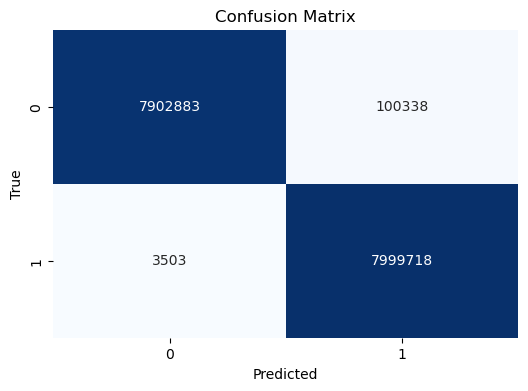

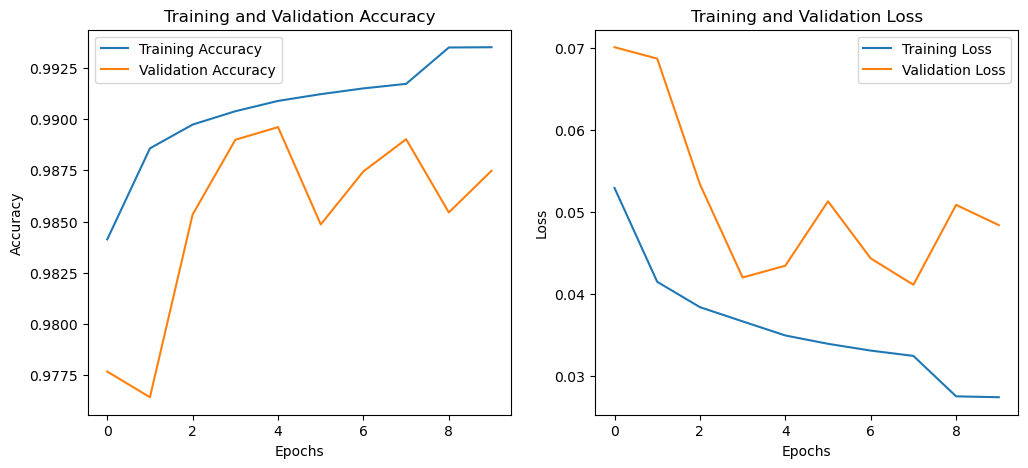

2024-11-29 11:54:40,175 - INFO - Training completed with GPU


INFO:tensorflow:Assets written to: Export Model\FCNN_model.tf\assets


2024-11-29 11:54:40,605 - INFO - Assets written to: Export Model\FCNN_model.tf\assets
2024-11-29 11:54:40,630 - INFO - Model saved successfully


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class GPUConfig:
    @staticmethod
    def setup_gpu() -> bool:
        """
        Configure GPU settings for optimal performance.
        Returns True if GPU is available and configured, False otherwise.
        """
        try:
            if tf.test.is_built_with_cuda():
                physical_devices = tf.config.list_physical_devices('GPU')
                if physical_devices:
                    try:
                        for device in physical_devices:
                            tf.config.experimental.set_memory_growth(device, True)
                        logging.info(f"GPU configured successfully: {physical_devices[0].name}")
                        return True
                    except RuntimeError as e:
                        logging.warning(f"Memory growth configuration failed: {str(e)}")
                        try:
                            tf.config.set_logical_device_configuration(
                                physical_devices[0],
                                [tf.config.LogicalDeviceConfiguration(memory_limit=1024 * 4)]
                            )
                            logging.info("GPU configured with memory limit")
                            return True
                        except RuntimeError as e:
                            logging.warning(f"Memory limit configuration failed: {str(e)}")
            
            logging.warning("No GPU available or configuration failed. Using CPU.")
            os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  
            return False
            
        except Exception as e:
            logging.error(f"GPU configuration error: {str(e)}")
            os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  
            return False

class FCNNModel:
    def __init__(self, input_dim: int, batch_size: int = 32):
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.model = self._create_model()
        self.callbacks = self._create_callbacks()

    def _create_model(self) -> Sequential:
        policy = 'mixed_float16' if tf.config.list_physical_devices('GPU') else 'float32'
        tf.keras.mixed_precision.set_global_policy(policy)
        
        model = Sequential([
            Dense(128, activation='relu', input_dim=self.input_dim),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        if policy == 'mixed_float16':
            optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        return model

    def _create_callbacks(self) -> list:
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                min_delta=0.001
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=0.00001,
                min_delta=0.001
            )
        ]

class ModelTrainer:
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y

    def train_and_evaluate(self) -> Tuple[Sequential, Dict[str, Any]]:
        fcnn = FCNNModel(input_dim=self.X.shape[1])
        
        history = fcnn.model.fit(
            self.X, self.y,
            validation_split=0.2,
            epochs=10,
            batch_size=fcnn.batch_size,
            callbacks=fcnn.callbacks,
            verbose=1
        )
        
        # Generate evaluation metrics
        metrics = self._evaluate_model(fcnn.model)
        
        # Plot accuracy and loss
        self._plot_training_results(history)
        
        return fcnn.model, metrics
    
    def _plot_training_results(self, history) -> None:
        """Plot training and validation accuracy and loss."""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        epochs = range(len(acc))
        
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()

    def _evaluate_model(self, model: Sequential) -> Dict[str, Any]:
        y_pred = (model.predict(self.X, batch_size=32) > 0.5).astype(int)
        report = classification_report(self.y, y_pred, output_dict=True)
        cm = confusion_matrix(self.y, y_pred)

        fcnn_result = [{
            'Classifier': 'FCNN (Fully Connected Neural Network)',
            'Class 0 - Precision': report['0']['precision'],
            'Class 0 - Recall': report['0']['recall'],
            'Class 0 - F1-Score': report['0']['f1-score'],
            'Class 1 - Precision': report['1']['precision'],
            'Class 1 - Recall': report['1']['recall'],
            'Class 1 - F1-Score': report['1']['f1-score'],
            'Average - Precision': report['macro avg']['precision'],
            'Average - Recall': report['macro avg']['recall'],
            'Average - F1-Score': report['macro avg']['f1-score'],
            'Accuracy': report['accuracy'],
            'Confusion Matrix': cm
        }]

        fcnn_result_df = pd.DataFrame(fcnn_result)
        display(Markdown("### Classification Report of FCNN (Fully Connected Neural Network)"))
        display(fcnn_result_df)

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Plot Precision-Recall Curve
        return {
            'classification_report': report,
            'confusion_matrix': cm
        }

def main(df_norm: pd.DataFrame) -> None:
    try:
        gpu_available = GPUConfig.setup_gpu()
        
        X = df_norm.drop(columns=['Burn_Label']).values
        y = df_norm['Burn_Label'].values
        
        trainer = ModelTrainer(X, y)
        
        model, metrics = trainer.train_and_evaluate()
        
        logging.info(f"Training completed {'with GPU' if gpu_available else 'on CPU'}")
        
        try:
            model_save_dir = r'Export Model'
            model_save_path = os.path.join(model_save_dir, 'FCNN_model.tf')
            model.save(model_save_path)
            logging.info("Model saved successfully")
        except Exception as e:
            logging.error(f"Error saving model: {str(e)}")
            
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main(df_norm)